# 6章 学習に関するテクニック

## 6.1 パラメータの更新

損失関数の値をできるだけ小さくするような重みパラメータを探索する。これは**最適化**問題を解いていると言える。

重みパラメータを最適化する手法はいくつか存在し、例えば今までは**SGD**(**確率的勾配降下法**)を用いていた。

### SGD(確率的勾配降下法)

SGDにおけるパラメータ更新の式は以下のようになる。

$$ \bold{W} \leftarrow \bold{W} - \eta\frac{\partial{L}}{\partial{\bold{W}}} $$

ここで $\bold{W}$ は重みパラメータを、 $\eta$ は学習係数を、$\frac{\partial{L}}{\partial{\bold{W}}}$ は$\bold{W}$に関する損失関数の勾配を表している。また左矢印（$\leftarrow$）は右辺を左辺に代入することを意味している。

SGDは「勾配方向に一定の距離進んで行く」という単純な方法をとっている。

このSGDをPythonのクラスとして実装する。他の最適化手法の実装と入れ替えられるように以下のフォーマットに従ってSGDクラスを実装する。

- インスタンス変数として`lr`という変数を持つ。`lr`は**learning rate**、つまり学習係数を変数として保持する。
- メソッド`update`を実装する。このメソッドは引数として `params` と `grads` を受け取り、重みパラメータの更新を行う。
  - `params` : 重みパラメータを保持するディクショナリ変数。例えば`params['W1]`でW1(1層目)の重みパラメータが取得できる。
  - `grads`  : 勾配情報を保持するディクショナリ変数。例えば`grads['W1']`でW1(1層目)の重みパラメータの勾配が取得できる。

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

このSGDクラスを用いて重みパラメータの最適化を行うことができる。イメージとしては以下のような使い方が想定される。
```python
network = TwoLayerNet(...)
optimizer = SGD() # 学習率の初期値を指定したいなら SGD(lr=0.01) のように指定する。

for i in range(10000): # 1万イテレーション
    ...
    x_batch, t_batch = get_mini_batch(...) # ミニバッチを取り出す
    grads = network.gradient(x_batch, t_batch) # 重みパラメータに関する損失関数の勾配を取り出す
    params = network.params # 重みパラメータを取り出す
    optimizer.update(params, grads) # パラメータの最適化
    ...
```
以降の最適化手法の実装も先述のフォーマットに則って実装することでoptimizerの中身を入れ替えて最適化手法を切り替えることができる。

### SGDの欠点
単純で分かりやすい（=実装しやすい）SGDだが、問題によって非効率な場合がある。例えば損失関数のグラフの形状が等方的でない場合、言い換えると伸びた形状の関数の場合、非効率な経路で探索することになる。

$f(x,y) = \frac{1}{20}x^{2} + y^{2}$ の関数の最小値の探索を例にSGDの欠点について考える。


$f(x,y) = \frac{1}{20}x^{2} + y^{2}$ の関数のグラフは以下のようになっている。

https://www.desmos.com/3d/naged619ac

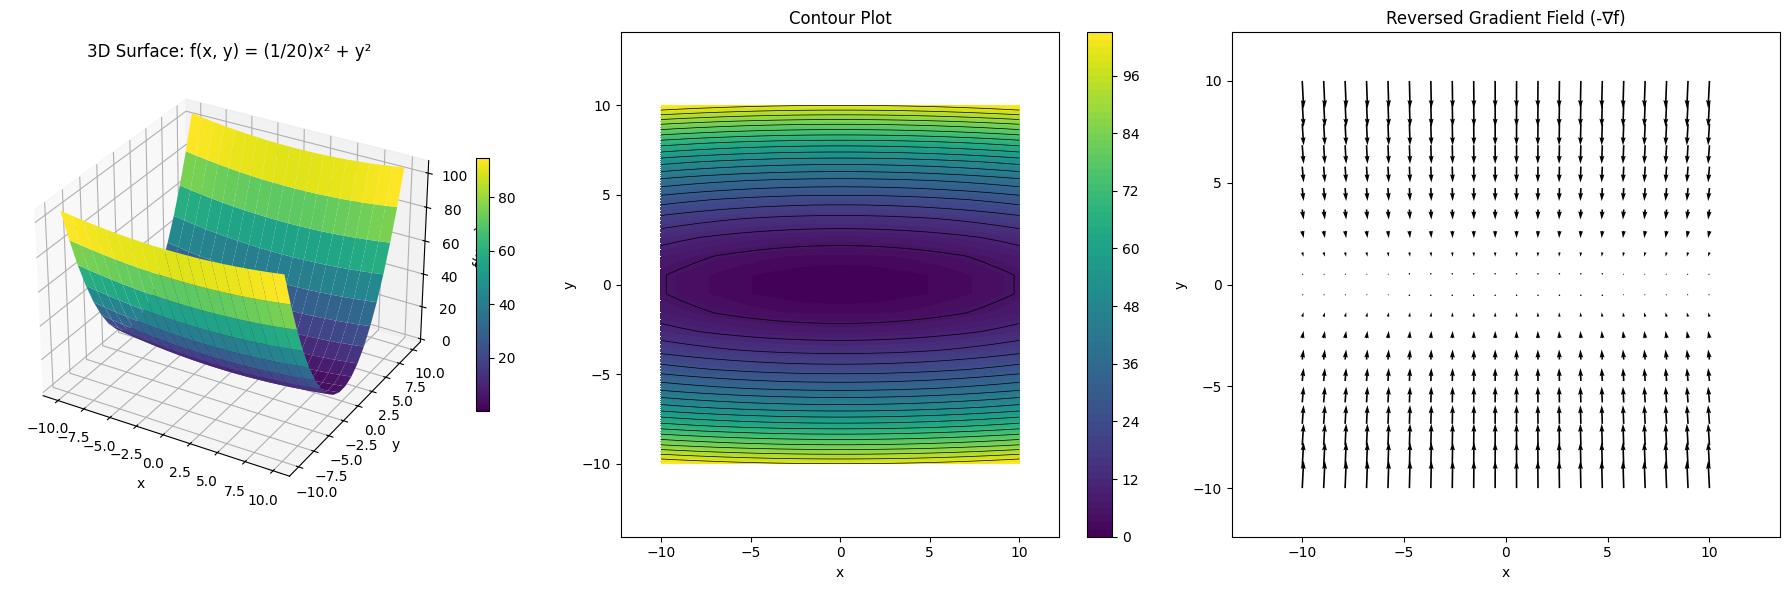

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Sparse grid for gradient field
x = np.linspace(-10, 10, 20)
y = np.linspace(-10, 10, 20)
x_grid, y_grid = np.meshgrid(x, y)

# Function definition
z = (1/20) * x_grid**2 + y_grid**2

# Gradient and reversed gradient: ∇f = [(1/10)x, 2y], reversed: -∇f
df_dx = -(1/10) * x_grid
df_dy = -2 * y_grid

# ==============================
# Plotting
fig = plt.figure(figsize=(18, 6))

# 1. 3D Surface Plot
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
surf = ax1.plot_surface(x_grid, y_grid, z, cmap='viridis', edgecolor='none')
ax1.set_title('3D Surface: f(x, y) = (1/20)x² + y²')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('f(x, y)')
fig.colorbar(surf, ax=ax1, shrink=0.5)

# 2. Contour Plot
ax2 = fig.add_subplot(1, 3, 2)
contourf = ax2.contourf(x_grid, y_grid, z, levels=100, cmap='viridis')
contour = ax2.contour(x_grid, y_grid, z, levels=20, colors='black', linewidths=0.5)
# ax2.clabel(contour, fmt='%.1f', colors='black', fontsize=8)
ax2.set_title('Contour Plot')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.axis('equal')
fig.colorbar(contourf, ax=ax2)

# 3. Reversed Gradient Field with Contours
ax3 = fig.add_subplot(1, 3, 3)
# contourf2 = ax3.contourf(x_grid, y_grid, z, levels=50, cmap='viridis', alpha=0.6)
# ax3.contour(x_grid, y_grid, z, levels=10, colors='black', linewidths=0.5)
ax3.quiver(x_grid, y_grid, df_dx, df_dy, angles='xy', scale=400, width=0.003, linewidth=1)
ax3.set_title('Reversed Gradient Field (-∇f)')
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.axis('equal')
# fig.colorbar(contourf2, ax=ax3)

# Layout and display
plt.tight_layout()
plt.show()


この関数に対して勾配降下法を用いて極小値を求める経路を図示する。
ここでは後のことを考えて最適化手法を切り替えられるように経路を図示する関数 `plot_optimization_path` を実装する。

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- Function and its gradient ---
def f(x, y):
    return (1/20) * x**2 + y**2

def grad_f(x, y):
    return {'x': (1/10) * x, 'y': 2 * y}

# --- General optimization path plotter ---
def plot_optimization_path(optimizer, init_x, init_y, num_steps=50):
    # Initialize parameters
    params = {'x': init_x, 'y': init_y}
    trajectory = [np.array([params['x'], params['y']])]

    # Optimization loop
    for _ in range(num_steps):
        grads = grad_f(params['x'], params['y'])
        optimizer.update(params, grads)
        trajectory.append(np.array([params['x'], params['y']]))
    trajectory = np.array(trajectory)

    # Contour plot setup
    x_vals = np.linspace(-10, 10, 400)
    y_vals = np.linspace(-10, 10, 400)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = f(X, Y)

    # Plot
    plt.figure(figsize=(8, 8))
    contours = plt.contour(X, Y, Z, levels=30, cmap='viridis')

    plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', color='red', linewidth=1, markersize=2, label='Optimization Path')
    plt.scatter(trajectory[0, 0], trajectory[0, 1], color='blue', s=30, label='Start')
    plt.scatter(0, 0, color='black', s=30, label='Minimum')

    plt.title(f'Optimization Path with {optimizer.__class__.__name__}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.show()


続いて、関数 `plot_optimization_path` を用いてSGDによって極小値を探索する経路を図示する。

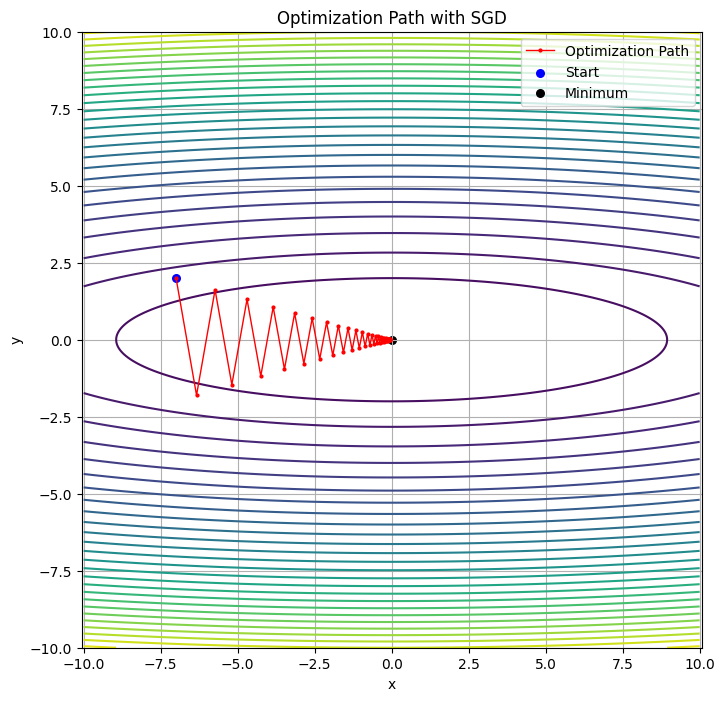

In [4]:
optimizer = SGD(lr=0.95)
plot_optimization_path(optimizer, init_x=-7.0, init_y=2.0, num_steps=50)

上図のように最小値を求める経路が上下にジグザグしてしまっており、非効率な経路を辿ってしまっている。このようなSGDを用いると発生する問題を改善するためにSGDの代わりとなる**Momentum**、 **AdaGrad**、 **Adam**の3つの手法について確認する。

### Momentum

Momentumにおけるパラメータ更新の式は以下のようになる。

$$ \bold{v} \leftarrow \alpha \bold{v} - \eta\frac{\partial{L}}{\partial{\bold{W}}} $$

$$ \bold{W} \leftarrow \bold{W} + \bold{v}  $$

ここで $\bold{W}$ は重みパラメータを、 $\eta$ は学習係数を、$\frac{\partial{L}}{\partial{\bold{W}}}$ は$\bold{W}$に関する損失関数の勾配を表している。また左矢印（$\leftarrow$）は右辺を左辺に代入することを意味している。

そしてSGDにはなかった変数 $\bold{v}$ が登場しており、これは物理で言う「速度」に対応する変数である。
この速度変数 $\bold{v}$ をパラメータ更新の際に残しておくことで勾配の向きが急転換するような経路でも（速度があると急には方向転換できないので）ジグザグしない経路で進むことができる。

また、 $\alpha$ は0.9等の値を設定し、勾配がない時は徐々に止まるようにする役割を持つ。これは物理で言う空気抵抗や地面との摩擦を表している。

このようにMomentumは「ボールが地面を転がっていくような挙動で探索していく」方法をとっている。

MomentumをPythonのクラスとして実装する。SGDの時と同様に決まったフォーマットに従ってクラスを実装する。

In [5]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

基本的にはSGDの時と同じように数式に忠実に実装している。
速度vはMomentumクラスの初期化時にはNoneのままなので、パラメータ更新の際にself.vがNoneなら速度を0として初期化する処理が入っている。

Momentumクラスの実装ができたので関数 `plot_optimization_path` を用いてMomentumによる極小値探索の経路を図示する。

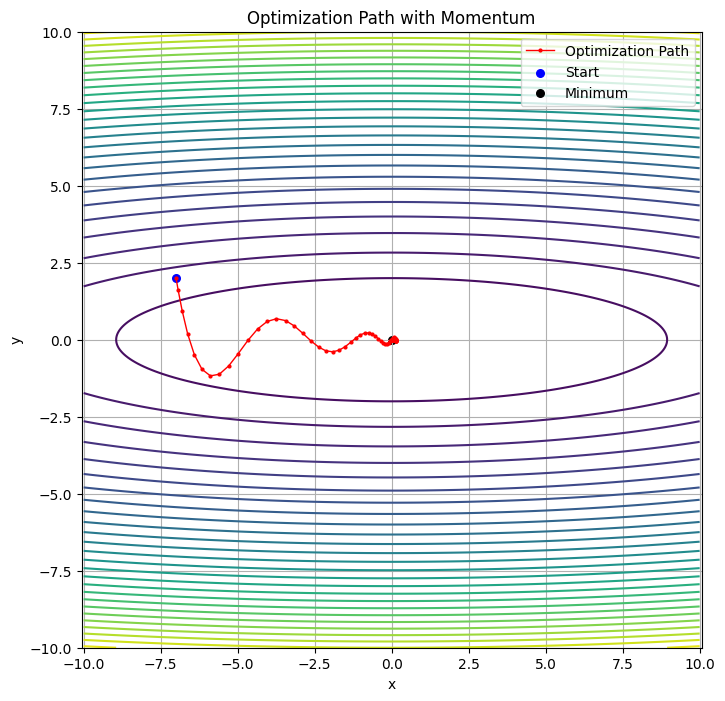

In [44]:
optimizer = Momentum(lr=0.1, momentum=0.85)
plot_optimization_path(optimizer, init_x=-7.0, init_y=2.0, num_steps=200)

MomentumではSGDと比べてジグザグ度合いが軽減されており、x軸方向で見るとより早く極小値に向かっていく様子が見て取れる。x軸方向では常に極小値方向に勾配が向いているのに対しy軸方向では向きの正負が交互に打ち消しあって徐々にy軸方向の速度が0になっていくためである。

### AdaGrad

AdaGradにおけるパラメータ更新の式は以下のようになる。

$$ \bold{h} \leftarrow \bold{h} + \frac{\partial{L}}{\partial{\bold{W}}} \odot \frac{\partial{L}}{\partial{\bold{W}}} $$

$$ \bold{W} \leftarrow \bold{W} - \eta\frac{1}{\sqrt{\bold{h}}}\frac{\partial{L}}{\partial{\bold{W}}} $$

ここで $\bold{W}$ は重みパラメータを、 $\eta$ は学習係数を、$\frac{\partial{L}}{\partial{\bold{W}}}$ は$\bold{W}$に関する損失関数の勾配を表している。また左矢印（$\leftarrow$）は右辺を左辺に代入することを意味している。

また、新しく変数 $\bold{h}$ が登場しているが、これは今までに探索した勾配の値を二乗和として保持しておくためのものである。
パラメータ更新の際にはこの $\bold{h}$ の二乗根の逆値を学習係数（学習率）に乗算することで、これまで学習した勾配の値の総量に応じて学習量を小さくしている。

つまり、AdaGradの手法というのは「最初に大きく学習して、次第に小さく学習していく」という手法である。

AdaGradをPythonのクラスとして実装する。これまでと同様に決まったフォーマットに従ってクラスを実装する。

In [33]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
    

基本的に数式に忠実に実装している。
変数hはAdaGradクラスの初期化時にはNoneのままなので、パラメータ更新の際にself.hがNoneならhを0として初期化する処理が入っている。

また、最後の行
```python
params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
```
のようにhの二乗根に1e-7という小さな値を足しているのはhの中に0があった際に0除算とならないようにするための値である。

AdaGradクラスの実装ができたので関数 `plot_optimization_path` を用いてAdaGradによる極小値探索の経路を図示する。

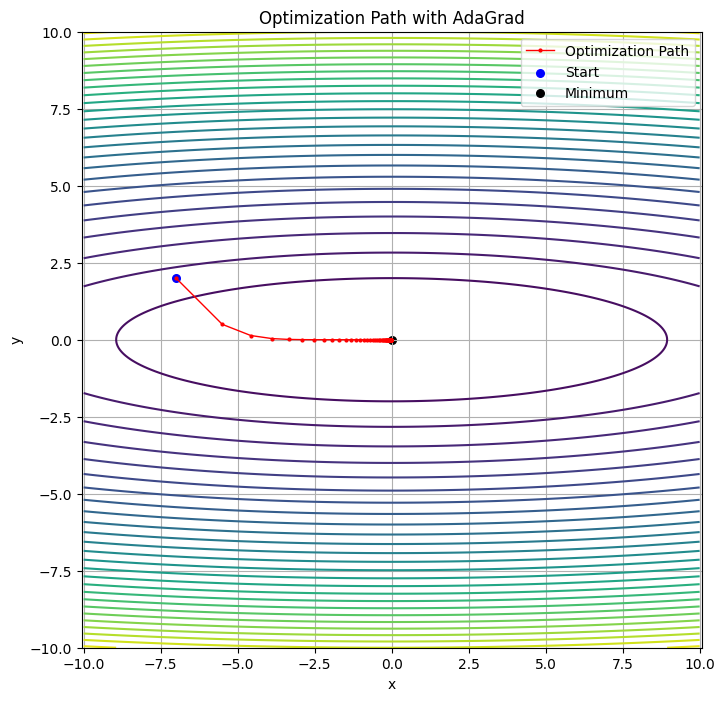

In [39]:
optimizer = AdaGrad(lr=1.5)
plot_optimization_path(optimizer, init_x=-7.0, init_y=2.0, num_steps=50)

上図を見ると極小値に向かって効率良く探索していることがわかる。最初はy軸方向の勾配が大きいので大きく動き、その分学習係数が小さくなるので次第に進む距離が小さくなっていく。それによりy軸方向での余分な動きが抑制される形となっている。

### Adam

AdamはAdaGradとMomentumの手法を融合するとより効率的に重みパラメータ空間を探索できるのではないか、というアイデアがベースとなっている最適化手法である。つまりMomentumのように探索中の速度を考慮しつつAddGradのように学習率を調整する手法ということになる。

In [9]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

関数 `plot_optimization_path` を用いてAdamによる極小値探索の経路を図示する。

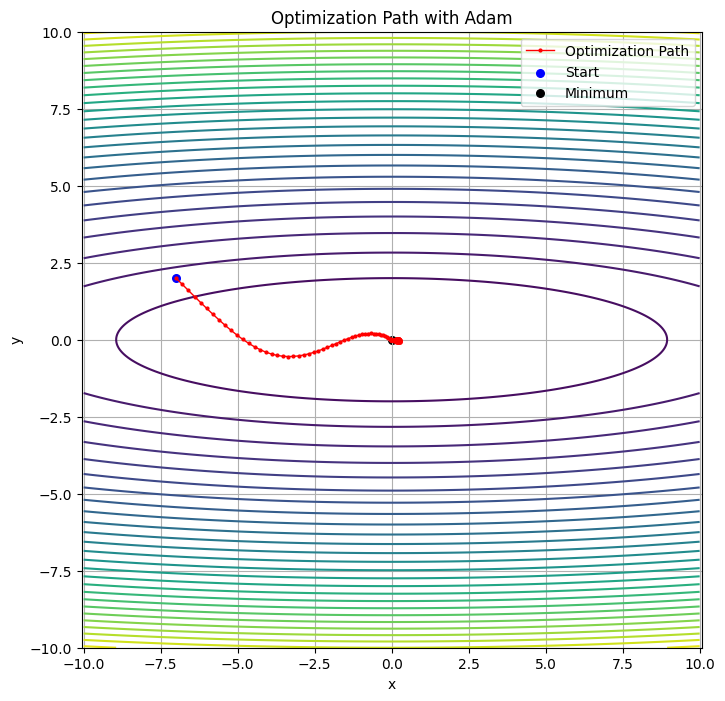

In [42]:
optimizer = Adam(lr=0.2)
plot_optimization_path(optimizer, init_x=-7.0, init_y=2.0, num_steps=100)

Momentumの時と比べてy軸で揺れないようになっているのがわかる。学習率が適応的に調整されるためにより効率的に極小値に近づくことができるようになっている。

### MNISTデータセットによる更新手法の比較

実際にMNISTデータセットを用いて各更新手法を試してみると、以下のような結果を得られる。

![a](fig1.png)

## 重みの初期値

### 重みの初期値を0にする？

重みの初期値によって学習の成否が分かれることがある。Weight Decay（荷重減衰）という方法では重みパラメータを小さくなるように学習させることで過学習を起きにくくさせる方法であるが、そのためにすべての重みを0から始めるのは望ましくない。

重みパラメータの初期値を均一な値にすると学習を進めてもニューロンの区別が付かない状態となり、複数のニューロンを用いる理由がなくなってしまう。この重みの対称性を防ぐためには重みの初期値にランダムな値を用いるのが良い。

### 隠れ層のアクティベーション分布

隠れ層のアクティベーション（隠れ層の活性化関数後の出力データのこと）の分布をみることで多くの知見を得ることができる。

試しに以下のコードを用いて隠れ層のアクティベーションを確認してみる。

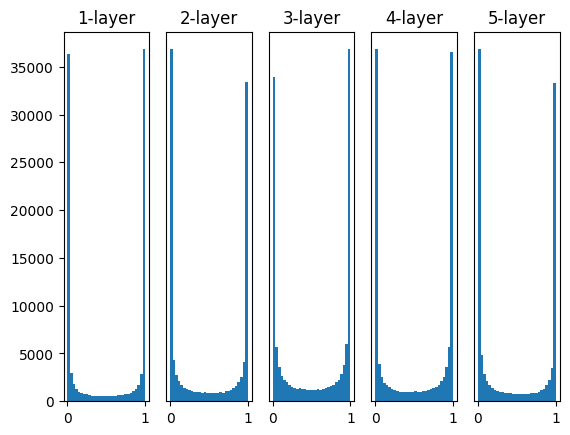

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個のデータ
node_num = 100  # 各隠れ層のノード（ニューロン）の数
hidden_layer_size = 5  # 隠れ層が5層
activations = {}  # ここにアクティベーションの結果を格納する

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

上図は活性化関数にsigmoid関数を用いて、標準偏差1のガウス分布に従って1000個のデータをランダムに生成して入力として与えた際の各層のアクティベーションの分布をヒストグラムとして表したものである。
この時の重みパラメータの初期値は標準偏差1のガウス分布にしたがってランダムに生成している。
結果としてアクティベーションは0と1に分布が偏っており、sigmoid関数では出力が0または1に近づくほどその微分の値が0に近づいていく。従って、このデータ分布では逆伝播における勾配の値がどんどん小さくなって行き、勾配消失の問題が懸念される。

続いて重みパラメータを標準偏差0.01のガウス分布に従って生成し、それ以外は同条件としてアクティベーションの分布を確認する。

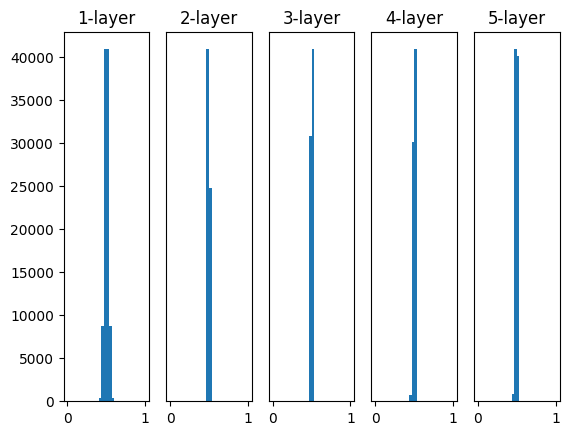

In [12]:
x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * 0.01 # ここで標準偏差を0.01に調整している
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

重みパラメータの初期値を標準偏差が0.01のガウス分布にしたがって生成した場合だと、分布が0.5付近に偏った。この場合勾配消失の心配は無いが、多くのニューロンがほとんど同じ出力をしているというのは多くのニューロンの存在する意味がないということになる。つまり、アクティベーションが偏っている場合、その学習においては表現力が狭まっているという点で望ましくないことだと言える。

従って、アクティベーションの分布はなるべく偏らずに適度な広がりを持つことが求められる。

アクティベーションの分布を見たときに適度に広がりを持つように、「Xavierの初期値」を使ってみる。
Xavierの初期値は前層のノードの数をnとしたときに、標準偏差 $\frac{1}{\sqrt{n}}$ である分布に従って初期値を決定する方法である。
先ほどの1000個のデータの例で試してみる。

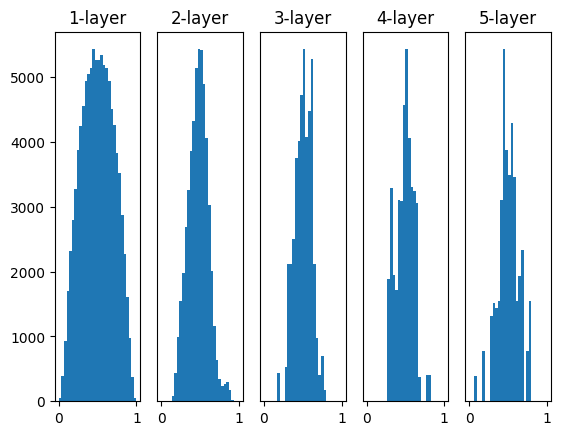

In [13]:
x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * 0.1 # Xavierの初期値は100個のノードがある場合は0.1となる
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

Xavierの初期値によって重みパラメータの初期値を生成したところ、アクティベーションの分布が適度に広がるようになった。つまりより高い表現力で学習を進めることができるようになっていることがわかる。

### ReLUの場合の重みの初期値

Xavierの初期値はsigmoid関数やtanh関数等の活性化関数が線形（中央付近で線形とみなせるなら良い？）の場合に適している。しかしReLU関数は中央付近で線形ではないのでReLUに特化した「Heの初期値」を使うことが好ましい。Heの初期値は前層のノード数がnのとき、標準偏差が$\sqrt{\frac{2}{n}}$のガウス分布を用いて生成する方法である。

実際にReLUを活性化関数として試してみる。
まずは標準偏差が0.01のガウス分布で重みの初期値を生成した場合を確認する。

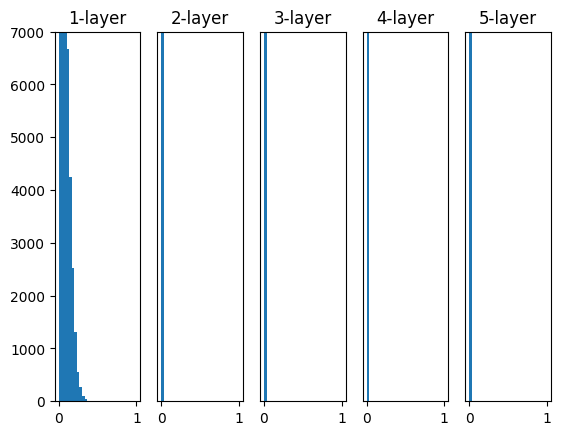

In [14]:
x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * 0.01 # 標準偏差0.01のガウス分布に従って重みを生成
    a = np.dot(x, w)
    z = relu(a)
    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

続いて、Xavierの初期値を用いた場合のアクティベーションを確認する。

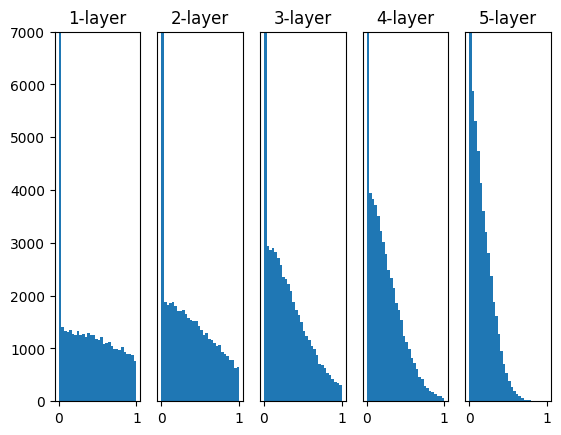

In [15]:
x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * 0.1 # Xavierの初期値
    a = np.dot(x, w)
    z = relu(a)
    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

「Heの初期値」の場合についても確認してみる。

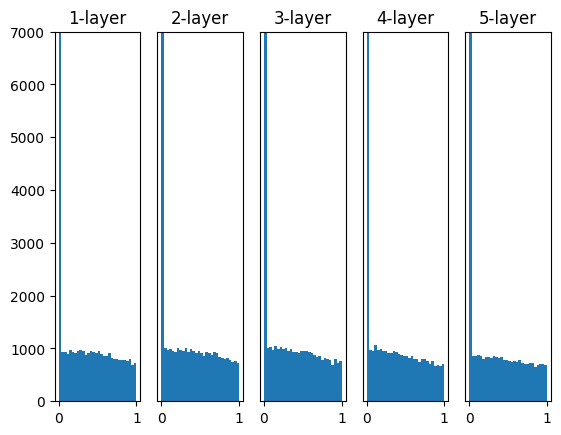

In [16]:
x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * np.sqrt(0.02) # Heの初期値
    a = np.dot(x, w)
    z = relu(a)
    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

活性化関数がtanh関数の場合について、ガウス分布の標準偏差を1、Xavierの初期値、Heの初期値の3通りで試してみる。

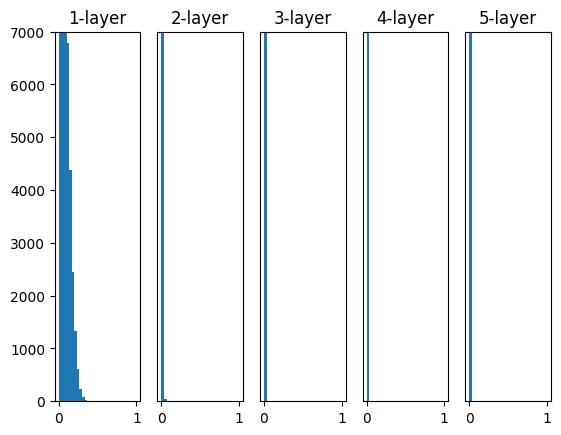

In [17]:
x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x, w)
    z = tanh(a)
    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

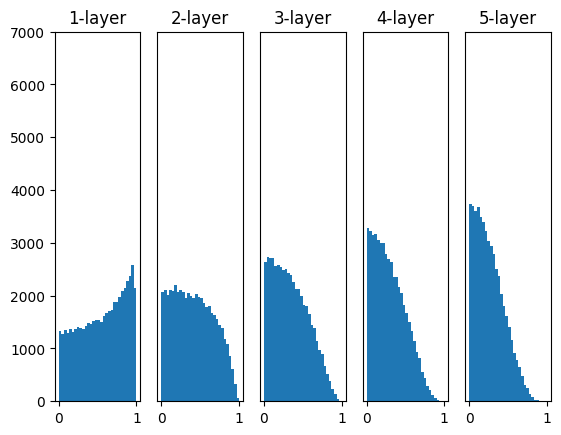

In [18]:
x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * 0.1
    a = np.dot(x, w)
    z = tanh(a)
    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

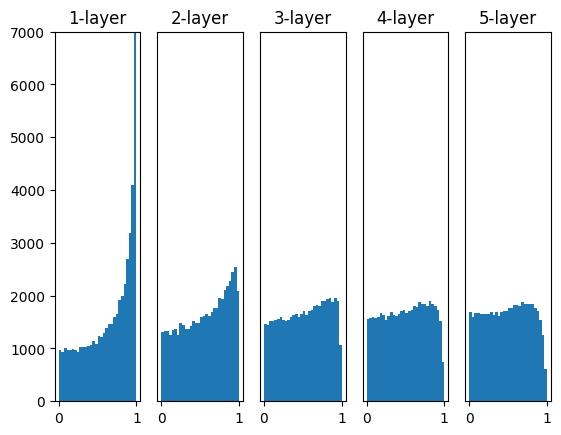

In [19]:
x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    w = np.random.randn(node_num, node_num) * np.sqrt(0.02)
    a = np.dot(x, w)
    z = tanh(a)
    activations[i] = z

# ヒストグラムを描画
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

### MNISTデータセットによる重み初期値の比較



実際に重みの初期値の与え方を変えることでニューラルネットワークの学習にどれほど影響があるのかを確認する。

![alt text](fig2.png)

## Batch Normalization

Batch Normalizationには次の利点がある。

- 学習を速く進行させることができる（学習係数を大きくできる）
- 初期値にそれほど依存しない（初期値に対してそこまで神経質にならなくてよい）
- 過学習を抑制する（Dropoutなどの必要性を減らす）

Batch Normはミニバッチごとにデータの正規化する。（平均0、分散1）

データxに対して、以下のようにして正規化を行う。
$$\hat{x} = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}}$$

また、Batch Normでは固有のスケールとシフトでデータを変換する。
$$y_i = \gamma \hat{x}_i + \beta$$

$\gamma$と$\beta$はBatch Normにおけるパラメータで、学習によって自動的に更新されていく。初期値は$\gamma = 1$、$\beta = 0$である。

### Batch Normalizationの評価

実際にBatch Normレイヤを使ってどのような効果があるのか確認する。
![alt text](fig3.png)

## 正則化

機械学習では汎化性能を獲得したい → 訓練データに適応しすぎている状態（過学習）は良くない。

過学習が起きる要因として
- パラメータを大量に持ち、表現力の高いモデルであること
- 訓練データが少ないこと

の2つがあげられる。

以下では意図的に過学習を起こして確認する。

![alt text](fig4.png)

### Weight Decay

過学習を抑えるための手法としてWeight Decay（荷重減衰）と呼ばれるものがある。

損失関数にL2ノルム（ $ \frac{1}{2} \lambda \bold{W} $ ）を加えることによって重みパラメータが大きくなるのを抑制する手法である。

ここで、Weight Decayを用いて過学習を抑制した結果も確認する。

![alt text](fig5.png)

### Dropout

過学習を抑制する方法としてWeight Decayは簡単に実装できてある程度の効果が見込める手法であるが、モデルが複雑になるとWeight Decayだけでは対応が困難になる。そこでDropoutという手法がよく用いられている。

Dropoutはニューロンをランダムに消去しながら学習する手法であり、疑似的に一つのモデルでアンサンブル学習を行っていると考えることもできる。

以下ではDropoutの有無で過学習の抑制にどれほど効果があるのかを確認する。

![alt text](fig6.png)　　![alt text](fig7.png)

上がDropout無し、下がDropout有りでの結果であり、Dropout有りの方では無しの方と比べて過学習が抑制できていることがわかる。

## ハイパーパラメータの検証

ニューラルネットワークではハイパーパラメータが多く登場する。それらを適切な値に設定しなければ性能の悪いモデルになってしまう。
なるべく効率的にハイパーパラメータを設定するためには

- 訓練データ・テストデータとは別に検証データを用意して、そのデータを用いてハイパーパラメータの探索を行う
- ハイパーパラメータの探索範囲をおおまかに設定し、そこからランダムサンプリングして学習を回すのを繰り返す
  - 大まかにというのは「$10^{-3}$から$10^3$まで」のような対数スケールで指定する
  - この時の学習におけるエポックは小さく設定して良い

→　繰り返した学習の中から結果が良かった時のハイパーパラメータを参照し、よさそうなハイパーパラメータに範囲に目安をつけることで、おおよそ良いハイパーパラメータを見つけることができる。

実際にハイパーパラメータの学習係数とWeight Decayの$\lambda$（荷重減衰の強さ）を探索した様子を以下にグラフとして表示する。

